# CLIP 유사도 Matrix

> 런타임 유형 꼭 GPU 설정하기

> 빈칸을 채우고 실행하는 문제입니다.



In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\pc\appdata\local\temp\pip-req-build-2d52o3g3
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached regex-2024.4.16-cp37-cp37m-win_amd64.whl.metadata (41 kB)
   ---------------------------------------- 53.1/53.1 kB 2.7 MB/s eta 0:00:00
Using cached regex-2024.4.16-cp37-cp37m-win_amd64.whl (269 kB)
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369571 sha256=f501be0fedc38da10955a2e11ff525d960b2c473260e4b7c67dc0caf40503339
  Stored in directory: C:\Users\PC\AppData\Local\Temp\pip-ephem-wheel-cache-splhfqjt\wheels\fd\b9\c3\5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\PC\AppData\Local\Temp\pip-req-build-2d52o3g3'


In [2]:
!pip install ftfy regex tqdm
!pip install seaborn

In [3]:
import os
import torch
import clip
from PIL import Image
import torch.nn.functional as F

# 1. 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. CLIP 모델 불러오기
model, preprocess = clip.load("ViT-B/32", device=device)

# 3. 이미지 파일 목록 (./images 폴더에 저장되어 있어야 함)
image_filenames = [
    "cat.jpg",
    "dog.jpg",
    "car.jpg",
    "pizza.jpg",
    "guitar.jpg"
]
image_paths = [os.path.join("./images", f) for f in image_filenames]

# 4. 텍스트 프롬프트
# 기존 텍스트 + distractor 프롬프트 추가
text_prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of a pizza",
    "a photo of a guitar",
    "a photo of a horse",
    "a photo of a hamburger",
    "a photo of a piano"
]


# 5. 이미지 전처리 및 배치
image_tensors = [preprocess(Image.open(img_path).convert("RGB")) for img_path in image_paths]
image_input = torch.stack(image_tensors).to(device)

# 6. 텍스트 토큰화
text_tokens = clip.tokenize(text_prompts).to(device)

# 7. 특징 추출 (with torch.no_grad for inference)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

# 8. 정규화 (cosine similarity 위해 L2 normalization)
image_features = F.normalize(image_features, dim=1)
text_features = F.normalize(text_features, dim=1)

# 9. cosine similarity matrix 계산 (5x5)
similarity_matrix = image_features @ text_features.T

# 10. 출력
print("Cosine Similarity Matrix (Image × Text):")
print(similarity_matrix)

# 선택: 가장 유사한 텍스트 인덱스 출력
best_matches = similarity_matrix.argmax(dim=1)
for i, idx in enumerate(best_matches):
    print(f"Image {image_filenames[i]} → {text_prompts[idx]}")


100%|███████████████████████████████████████| 338M/338M [01:15<00:00, 4.68MiB/s]


Cosine Similarity Matrix (Image × Text):
tensor([[0.2939, 0.2354, 0.2007, 0.1892, 0.1875, 0.2204, 0.2080, 0.1933],
        [0.2327, 0.2853, 0.2080, 0.2167, 0.2044, 0.2386, 0.2122, 0.2083],
        [0.1907, 0.1934, 0.2640, 0.1790, 0.2018, 0.1842, 0.1874, 0.1886],
        [0.1614, 0.1734, 0.1747, 0.2881, 0.1647, 0.1807, 0.1855, 0.1636],
        [0.2165, 0.2131, 0.1887, 0.1953, 0.2772, 0.2091, 0.1945, 0.1876]])
Image cat.jpg → a photo of a cat
Image dog.jpg → a photo of a dog
Image car.jpg → a photo of a car
Image pizza.jpg → a photo of a pizza
Image guitar.jpg → a photo of a guitar


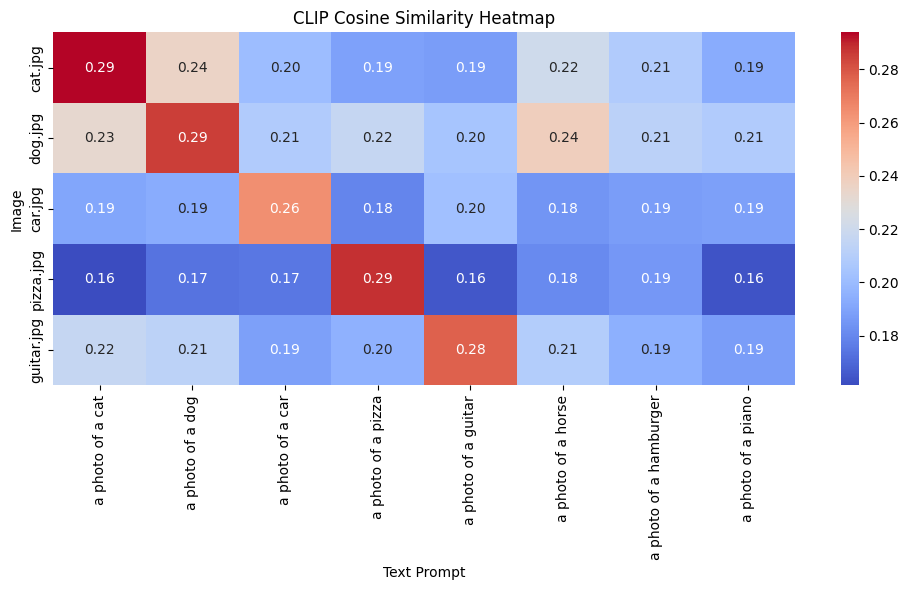

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 텍스트 & 이미지 라벨
labels = [
    "cat", "dog", "car", "pizza", "guitar"
]

# 2. similarity_matrix는 torch.Tensor → numpy로 변환
sim_matrix_np = similarity_matrix.cpu().numpy()

# 3. 히트맵 시각화
# 3. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(sim_matrix_np,
            xticklabels=text_prompts,
            yticklabels=image_filenames,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            cbar=True)

plt.xlabel("Text Prompt")
plt.ylabel("Image")
plt.title("CLIP Cosine Similarity Heatmap")
plt.tight_layout()
plt.show()

In [10]:
# 정답 인덱스 (앞의 5개 프롬프트가 정답쌍이라고 가정)
true_indices = torch.tensor([0, 1, 2, 3, 4]).to(device)

# Top-1 prediction
pred_indices = similarity_matrix.argmax(dim=1)

# Top-1 Accuracy
accuracy = (pred_indices == true_indices).float().mean().item()
print(f"\nTop-1 Accuracy: {accuracy * 100:.2f}%")



Top-1 Accuracy: 100.00%


In [9]:
# 각 이미지별로 유사도 높은 텍스트 상위 3개 인덱스 가져오기
top3_indices = similarity_matrix.topk(3, dim=1).indices

# Top-3 Accuracy 계산
top3_correct = torch.zeros(len(true_indices)).to(device)

for i in range(len(true_indices)):
    if true_indices[i] in top3_indices[i]:
        top3_correct[i] = 1.0

top3_accuracy = top3_correct.mean().item()
print(f"Top-3 Accuracy: {top3_accuracy * 100:.2f}%")

Top-3 Accuracy: 100.00%


#CLIP의 Cosine Similarity Heatmap 결과를 보고 정답쌍과 오답쌍의 유사도 차이가 어떻게 나타났는지 분석하시오. 또한 이러한 결과가 나타난 이유를 추론해보세요.

답:

정답쌍은 모두 Similarity Heatmap에서 확연한 색 차이를 보일 정도로 높은 유사도를 나타냈다.\
반면, 오답쌍은 대부분 0.2 이하의 낮은 유사도를 보여 정답쌍과 명확히 구별되는 양상을 확인할 수 있었다.\
이를 통해 CLIP 모델이 이미지와 텍스트 간의 관계를 정확하게 매칭하고 있음을 알 수 있다.

이러한 결과가 나타난 이유는 크게 두 가지로 볼 수 있다.\
첫째, CLIP은 대규모 이미지-텍스트 pair로 사전학습되어, 고양이나 피자처럼 시각적으로 뚜렷하고 명확한 개체들을 잘 인식할 수 있다.\
둘째, 모든 텍스트 프롬프트가 "a photo of ~" 형태로 형식이 통일되어, 모델이 비교 시 핵심 단어에 집중할 수 있었기 때문이다.